# Nodding Data Reduction
------------------------

This notebook shows the reduction path of a nodding observation in a multi-beam receiver.

Similar to a position-switched observation, two beams are selected for simultaneous observing (though the receiver can have more than two beams). In the first scan BEAM1 is looking at the source, while BEAM2 is looking at an assumed OFF position. In the next scan, BEAM2 will be looking at the source, while BEAM1 is looking at (another) OFF position. This will result in two position-switched solutions, which are then averaged for the final spectrum. 

The obvious advantage of this observing mode is that the telescope is always ON source, bringing the noise down by $\sqrt{2}$ compared to a classic position switched observation. Minus a small amount of slewing time of course. However, the beam separation in the receiver should be large enough to ensure there are good OFF positions, otherwise a proper Position Switching observation is needed with a large enough offset.

For fun, this notebook starts with  a matching getps() observation from another scan so we can confirm the improvement in signal/noise.

The data in this notebook were also presented in https://gbtdocs.readthedocs.io/en/latest/how-tos/data_reduction/gbtidl.html#basic-nodding in a similar GBTIDL data reduction.

## Background

The spectral line observed here is the NH$_3$ (1,1) line at 23.69 GHz with the K-band focal plane array (KFPA) receiver. This receiver has 7 beams: one central beam and six beams in a roughly hexagonal pattern around the central beam. The source is a position in the W3 cloud, a roughly two degree sized Giant Molecular Cloud (GMC) with active star formation.  See also https://herscheltelescope.org.uk/results/w3-star-forming-region/


In [1]:
# %matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.util.files import dysh_data
from pathlib import Path
from dysh.util.download import from_url

Future use of dysh_data:

 filename = dysh_data(example="nod-KFPA/data/TGBT22A_503_02.raw.vegas")
 
 filename = dysh_data(example="nod-KFPA/data/TGBT22A_503_02.raw.vegas.trim.fits")

In [3]:
url = "http://www.gb.nrao.edu/dysh/example_data/nod-KFPA/data/TGBT22A_503_02.raw.vegas.trim.fits"
savepath = Path.cwd() / "data"
filename = from_url(url, savepath)

Starting download...
TGBT22A_503_02.raw.vegas.trim.fits already downloaded at /home/teuben/GBT/redo/dysh2/notebooks/examples/data


This trimmed dataset is an extraction from a much larger dataset (19GB) and can take some time to load if it's the first time.

In [4]:
sdf = GBTFITSLoad(filename)

In [5]:
sdf.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,60,W3_1,-40.0,OnOff,1,23.694495,23.694495,1,1,31,1,324.227877,38.705979
1,61,W3_1,-40.0,OnOff,2,23.694495,23.694495,1,1,31,1,324.152608,39.012113
2,62,W3_1,-40.0,Nod,1,23.694495,23.694495,1,1,31,7,324.274257,38.419406
3,63,W3_1,-40.0,Nod,2,23.694495,23.694495,1,1,31,7,324.367171,38.285767


We will use scans 60 and 61 for the position-switching (PS) observation.

Also note for the 7-beam KFPA receiver, the central beam (fdnum=0) will be the source tracking beam for the PS observation.

In [6]:
sp1 = sdf.getps(scan=60,plnum=0,ifnum=0,fdnum=0).timeaverage()[1500:-1500]

/home/teuben/GBT/redo/dysh2/src/dysh/spectra/core.py:393: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


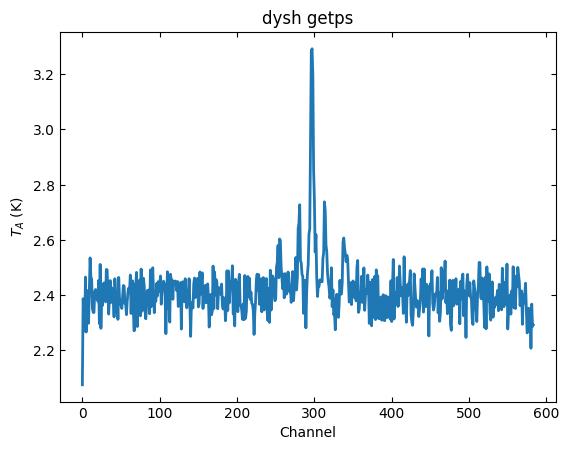

{'mean': <Quantity 2.41443907 K>,
 'median': <Quantity 2.40562378 K>,
 'rms': <Quantity 0.1005958 K>,
 'min': <Quantity 2.07529651 K>,
 'max': <Quantity 3.29220368 K>}

In [7]:
sp1s = sp1.smooth('box',51)
sp1s.plot(title='dysh getps',xaxis_unit="chan")
sp1s.stats()

Now the nodding method, using scans 62 and 63.  This will return one scanblock with two NodScan's, each representing a "PS" observation that need to be averaged to get the final spectrum.  We can do that with the timeaverage() function directly applying to this list of (two) NodScan's.  And for good measure we will smooth it a little bit as we did with the previous PS observation.

Normally the FITS header will contain information on which is BEAM1 and which is BEAM2. In this case beams 2 and 6 are the two nodding beams. For convenience we have dropped the first and last 1500 (of the 32768) channels of the spectrum to avoid edge effects. We leave it to the reader to view these beautiful edges.

In [8]:
sp2 = sdf.getnod(scan=62,ifnum=0,plnum=0).timeaverage()[1500:-1500]
sp2s = sp2.smooth('box',51)
sp2s.stats()

Using nodding beams [2, 6], use fdnum= to override these.


/home/teuben/GBT/redo/dysh2/src/dysh/spectra/core.py:393: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])
/home/teuben/GBT/redo/dysh2/src/dysh/spectra/core.py:393: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


{'mean': <Quantity 0.39304341 K>,
 'median': <Quantity 0.37967305 K>,
 'rms': <Quantity 0.09306823 K>,
 'min': <Quantity 0.25851575 K>,
 'max': <Quantity 1.23576891 K>}

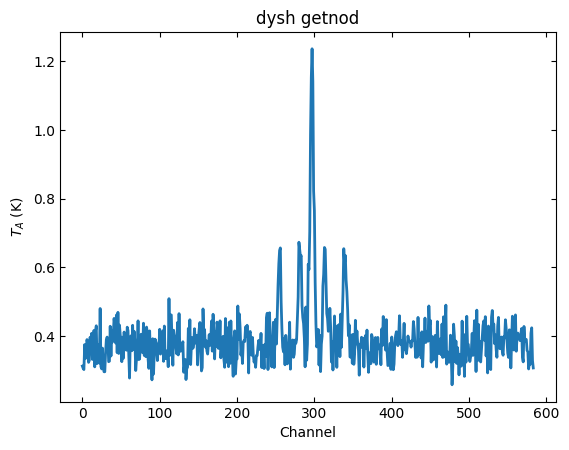

getps  RMS: 0.060980402393399205 K
getnod RMS: 0.04767002713482573 K


In [9]:
sp2s.plot(title='dysh getnod',xaxis_unit="chan")
print('getps  RMS:', sp1s[:200].stats()['rms'])
print('getnod RMS:', sp2s[:200].stats()['rms'])

The improvement of the RMS is not great, the 60 mK signal from the PS observation should have reduced to ~42 mK (this could be partially due to the different system temperature of the beams, the Nod scan has an 18% higher system temperature). 

In addition, the Nod spectrum shows the 4 side-peaks to be roughly the same, where the PS spectrum shows the outer two to be well below the middle two.  

Inspecting other beams from the KPFA suggests that the extent of the emission is larger than the ~1.5' separation between beams, where the OFF position in the PS observation was around 1 degree of the source.

Found nodding beams [2, 6], but you provided [3, 0]. Good luck


Using nodding beams [3, 0], use fdnum= to override these.


/home/teuben/GBT/redo/dysh2/src/dysh/spectra/core.py:393: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])
/home/teuben/GBT/redo/dysh2/src/dysh/spectra/core.py:393: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


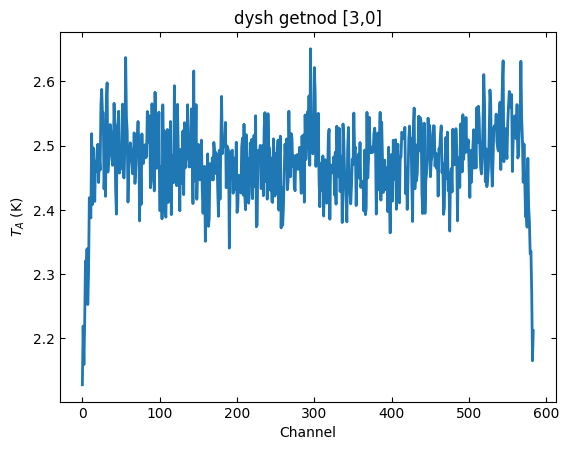

In [10]:
sp3 = sdf.getnod(scan=62,ifnum=0,plnum=0,fdnum=[3,0]).timeaverage()[1500:-1500]
sp3.smooth('box',51).plot(title='dysh getnod [3,0]',xaxis_unit="chan")


## Baseline Subtracted Spectra

Let us subtract a baseline and compare the two spectra on the same scale.

In [11]:
sp1s.baseline(model="cheby", degree=2, exclude=[200,400], remove=True)
sp2s.baseline(model="cheby", degree=2, exclude=[200,400], remove=True)

EXCLUDING [Spectral Region, 1 sub-regions:
  (23692939309.251465 Hz, 23700234917.771973 Hz) 
]
EXCLUDING [Spectral Region, 1 sub-regions:
  (23692939279.251465 Hz, 23700234887.771973 Hz) 
]


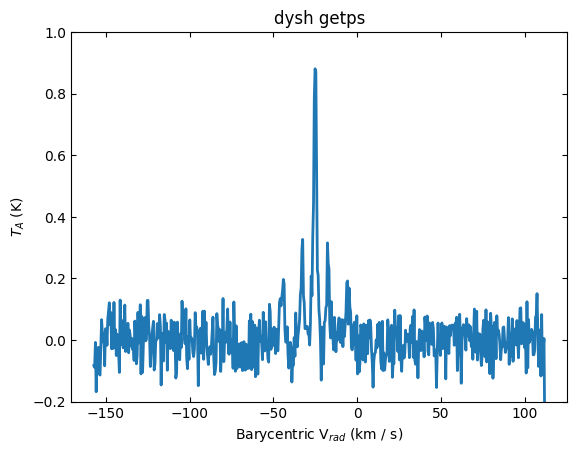

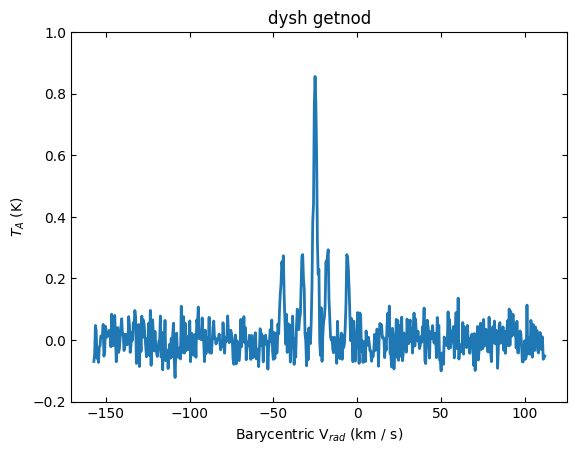

In [12]:
sp1s.plot(title='dysh getps',xaxis_unit="km/s", ymin=-0.2, ymax=1.0)
sp2s.plot(title='dysh getnod',xaxis_unit="km/s", ymin=-0.2, ymax=1.0)

In [13]:
print("PS  spectrum peak:", sp1s.stats()["max"])
print("NOD spectrum peak:", sp2s.stats()["max"])

PS  spectrum peak: 0.8804316609884038 K
NOD spectrum peak: 0.8554290850294709 K


Given that the RMS is about 0.060 K, the peaks of these two spectra agree well.
